In [79]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import nltk
#nltk.download('wordnet')

In [80]:
#creating dataframe from the dataset created in STEP 3
df = pd.read_csv("./enron.csv")
df = df.drop(["Email Folder"], axis=1)
#We will consider the number of emails found in the folders (sent and sent_mail)
#We will train model for different authors by using top authors according to email count.
#We Will consider 5,10 and 15 top authors and train and test model
Authors = df.value_counts(["Folder"])[:5]
#We will drop records where author name is empty or unnamed
df = df.loc[df["Folder"].isin(list(Authors.index.get_level_values(0)))].drop(["Unnamed: 0"], axis=1).reset_index(drop=True)
#We will drop the records if the email content is empty or NA
df = df[df["Text"]!=" "]
df = df[df["Text"]!="\n"]
df = df.dropna()

In [81]:
#This will print the count of top author emails
df["Folder"].value_counts()

mann-k          8167
kaminski-v      5926
dasovich-j      4805
germany-c       4571
shackleton-s    4003
Name: Folder, dtype: int64

In [82]:
#This function will change the records of each author to a number passed in parameter with name of author
def equal_dist(samples_per_author, df):
    df3 = pd.DataFrame(columns=["Author", "Folder", "File", "Text", "Raw Text"]) 
    for folder in df["Folder"].value_counts().index:
        df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)
    return df3
df = equal_dist(4000, df)

#prints the count of each author
print(df["Folder"].value_counts())
#df

mann-k          4000
kaminski-v      4000
dasovich-j      4000
germany-c       4000
shackleton-s    4000
Name: Folder, dtype: int64


/var/folders/zc/s6g9n2xd7y11gw_ngg0r8rx80000gn/T/ipykernel_59322/3434516801.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)


In [83]:
#Data Cleaning and processing (Remove punction marks, Lemmatization and Stop word removal)
#Lemmatization does morphological analysis of the words.
def Data_cleaning_processing(Data):
    #Remove punction marks
    removedpunc=[char for char in Data if char not in string.punctuation]
    removedpunc=''.join(removedpunc)

    #Lemmatization
    text1=''
    i=0
    Lemmatizer = WordNetLemmatizer()
    for i in range(len(removedpunc.split())):
        #v is verb
        text2=Lemmatizer.lemmatize(removedpunc.split()[i], pos="v")
        text1=text1+text2+' '
        
    #Stop word removal
    output = ""
    for w in text1.split():
        if w.lower():
            w = w.lower()
            if w not in stopwords.words("english"):
                output = output + w + " "
    
    return output

In [84]:
#Data Cleaning and processing 
cleaned_data = df["Text"].apply(lambda r: Data_cleaning_processing(r))
cleaned_data

0        hi kara havent write havent figure learn meet ...
1                      guess neil better start move plant 
2        want go weather get nice later week need gush ...
3        conflict 130 rose reliable show participate su...
4                                     drop yet set monday 
                               ...                        
19995    janet attached first draft consent amendment a...
19996    michael deepak michael moulton ena paper pulp ...
19997    tanya please talk either carol tana maybe need...
19998    kaye need redline first attach doc markup offi...
19999    sara shackleton enron north america corp 1400 ...
Name: Text, Length: 20000, dtype: object

In [85]:
#Adding column to Dataframe
df["cleaned_data"] = cleaned_data
df

,Author,Folder,File,Text,Raw Text,Message ID,cleaned_data
0,Kay,mann-k,4233.0,"Hi Kara,\n\nI haven't written because I haven'...",Message-ID: <23817868.1075846022763.JavaMail.e...,23817868.1075846022763.,hi kara havent write havent figure learn meet ...
1,Kay,mann-k,1893.0,"Guess Neil better start moving the plants, too.",Message-ID: <17101026.1075845964143.JavaMail.e...,17101026.1075845964143.,guess neil better start move plant
2,Kay,mann-k,2187.0,When do you want to go? The weather should be...,Message-ID: <25608111.1075845971706.JavaMail.e...,25608111.1075845971706.,want go weather get nice later week need gush ...
3,Kay,mann-k,338.0,I have a conflict at 130. Rose has been reliab...,Message-ID: <5086441.1075846036418.JavaMail.ev...,5086441.1075846036418.,conflict 130 rose reliable show participate su...
4,Kay,mann-k,919.0,I have not dropped it off yet. Can he be set ...,Message-ID: <24928454.1075845940517.JavaMail.e...,24928454.1075845940517.,drop yet set monday
...,...,...,...,...,...,...,...
19995,"Shackleton, Sara",shackleton-s,94.0,Janet:\n\nAttached is a first draft of the Con...,Message-ID: <3751582.1075858807878.JavaMail.ev...,3751582.1075858807878.,janet attached first draft consent amendment a...
19996,Sara,shackleton-s,1422.0,Michael and Deepak: Michael Moulton (the ENA ...,Message-ID: <22805352.1075844552335.JavaMail.e...,22805352.1075844552335.,michael deepak michael moulton ena paper pulp ...
19997,Sara,shackleton-s,1463.0,Tanya: Please talk to either Carol or Tana. ...,Message-ID: <24168779.1075844553284.JavaMail.e...,24168779.1075844553284.,tanya please talk either carol tana maybe need...
19998,Sara,shackleton-s,2381.0,Kaye: I need for you to redline the first att...,Message-ID: <2664644.1075844576102.JavaMail.ev...,2664644.1075844576102.,kaye need redline first attach doc markup offi...


In [86]:
#Labelencoder is used to encode the folder name column and save it in variable as our output label
y = df["Folder"]
LE = LabelEncoder()
Y = LE.fit_transform(y)
Y
# df["Folder"]=y
# df

array([3, 3, 3, ..., 4, 4, 4])

In [87]:
#Train model using Naive Bayes using kfold 10 splits
X = df["cleaned_data"].to_numpy()
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
training_accuracy = {k: [] for k in range(2000,24000,2000)}
testing_accuracy = {k: [] for k in range(2000,24000,2000)}
number_features = range(2000, 24000, 2000)
average_training_accuracy = []
average_testing_accuracy = []

In [88]:
#Train model using Naive Bayes using kfold 10 splits
# To select relevant features from all the features produced by Count Vectorizer we are using SelectKBest Features. 
i = 1
for train_index, test_index in kfold.split(X):
    #print(train_index)
    #print(test_index)
    X_train = X[train_index]
    X_test = X[test_index]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    #print(X_train)
    V = CountVectorizer()
    transformer = V.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    
    for k in range(2000,24000,2000):
        print("Round {} of CV Testing".format(i))
        print("Number of Features for SelectKBest = {}".format(k))
        fs = SelectKBest(k=k)
        X_train_transformed_new = fs.fit_transform(X_train_transformed, Y_train)
        X_test_transformed_new = fs.transform(X_test_transformed)

        model.fit(X_train_transformed_new, Y_train)
        training_accuracy1 = model.score(X_train_transformed_new, Y_train)
        testing_accuracy1 = model.score(X_test_transformed_new, Y_test)
        print(training_accuracy1)
        print(testing_accuracy1)
        training_accuracy[k].append(training_accuracy1)
        testing_accuracy[k].append(testing_accuracy1)
    i = i + 1
for k in training_accuracy.keys():
    average_training_accuracy.append(sum(training_accuracy[k])/len(training_accuracy[k]))
for k in testing_accuracy.keys():
    average_testing_accuracy.append(sum(testing_accuracy[k])/len(testing_accuracy[k]))

# We are searching for the optimal number of K best features by searching from 2000 to 24000 in increments of 2000. 
# The average training and testing accuracy list produced contains the accuracy averaged over 10 Folds for 2000 features selected all the way upto 22000 features selected in increments of 2000


Round 1 of CV Testing
Number of Features for SelectKBest = 2000
0.8062222222222222
0.7935
Round 1 of CV Testing
Number of Features for SelectKBest = 4000
0.8289444444444445
0.8075
Round 1 of CV Testing
Number of Features for SelectKBest = 6000
0.8413333333333334
0.8175
Round 1 of CV Testing
Number of Features for SelectKBest = 8000
0.8494444444444444
0.821
Round 1 of CV Testing
Number of Features for SelectKBest = 10000
0.8584444444444445
0.826
Round 1 of CV Testing
Number of Features for SelectKBest = 12000
0.863
0.829
Round 1 of CV Testing
Number of Features for SelectKBest = 14000
0.8628888888888889
0.828
Round 1 of CV Testing
Number of Features for SelectKBest = 16000
0.8632777777777778
0.8275
Round 1 of CV Testing
Number of Features for SelectKBest = 18000
0.8675555555555555
0.8305
Round 1 of CV Testing
Number of Features for SelectKBest = 20000
0.8757777777777778
0.8385
Round 1 of CV Testing
Number of Features for SelectKBest = 22000
0.8777222222222222
0.838
Round 2 of CV Testing

0.8737222222222222
0.8485
Round 9 of CV Testing
Number of Features for SelectKBest = 20000
0.8742222222222222
0.848
Round 9 of CV Testing
Number of Features for SelectKBest = 22000
0.8754444444444445
0.8515
Round 10 of CV Testing
Number of Features for SelectKBest = 2000
0.814
0.786
Round 10 of CV Testing
Number of Features for SelectKBest = 4000
0.8365
0.8135
Round 10 of CV Testing
Number of Features for SelectKBest = 6000
0.8464444444444444
0.818
Round 10 of CV Testing
Number of Features for SelectKBest = 8000
0.8577777777777778
0.8265
Round 10 of CV Testing
Number of Features for SelectKBest = 10000
0.8602222222222222
0.827
Round 10 of CV Testing
Number of Features for SelectKBest = 12000
0.8653888888888889
0.83
Round 10 of CV Testing
Number of Features for SelectKBest = 14000
0.8731666666666666
0.837
Round 10 of CV Testing
Number of Features for SelectKBest = 16000
0.875
0.837
Round 10 of CV Testing
Number of Features for SelectKBest = 18000
0.8754444444444445
0.8365
Round 10 of CV

In [89]:
#Printing out average training accuracy for each number of features selected 2000,4000,etc..
print("Average Training Accuracy")
print(average_training_accuracy)
print("Average Testing Accuracy")
print(average_testing_accuracy)

Average Training Accuracy
[0.8119, 0.8340055555555554, 0.8451944444444445, 0.8539666666666665, 0.8596777777777778, 0.8657222222222222, 0.870361111111111, 0.8718611111111112, 0.8736555555555554, 0.8755833333333334, 0.8778166666666667]
Average Testing Accuracy
[0.7988, 0.81615, 0.8237500000000001, 0.82835, 0.8309, 0.83515, 0.83995, 0.8406, 0.8420500000000001, 0.8433499999999998, 0.8454]


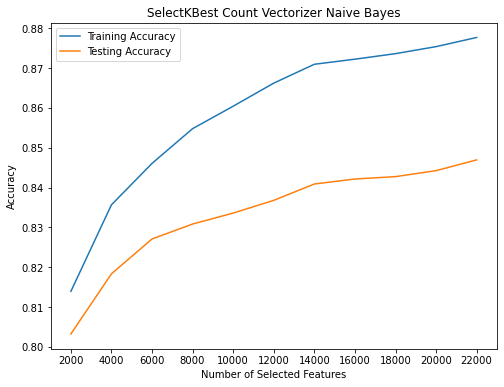

In [90]:
avg_train_Accuracy = [0.8139444444444444, 0.8356722222222223, 0.8460722222222221, 0.8547944444444445, 0.8604277777777778, 0.8662222222222222, 0.8709555555555555, 0.8722277777777776, 0.8736222222222223, 0.8753833333333333, 0.8776833333333334]
avg_test_Accuracy = [0.8032499999999999, 0.81835, 0.8271, 0.8308500000000001, 0.8335999999999999, 0.8368, 0.8408999999999999, 0.84215, 0.84275, 0.8442500000000001, 0.8469499999999999]

plt.plot(list(range(2000,24000,2000)), avg_train_Accuracy)
plt.plot(list(range(2000,24000,2000)), avg_test_Accuracy)
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy")
plt.title("SelectKBest Count Vectorizer Naive Bayes")
plt.xticks(range(2000, 24000, 2000))
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

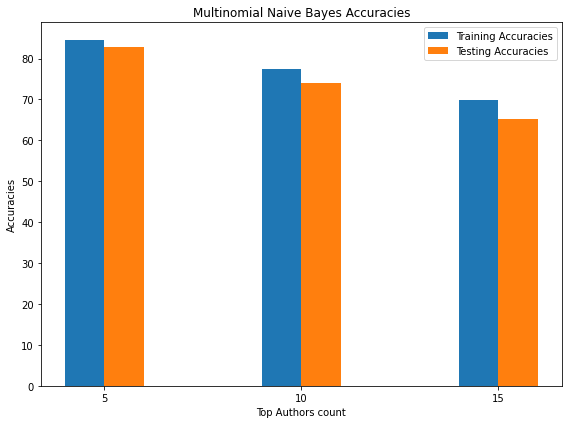

In [91]:
train_Accuracy =[0.8460722222222221*100,77.38977777777778,69.88187134502925]
test_Accuracy =[0.8271*100,73.90800000000002,65.24210526315789]

Labels = [5,10,15]
X_axis = np.arange(len(Labels))
length = np.arange(len(Labels))
width = 0.2
fig, x1 = plt.subplots()
rects1 = x1.bar(X_axis - width/2, train_Accuracy, width, label='Training Accuracies')
rects2 = x1.bar(X_axis + width/2, test_Accuracy, width, label='Testing Accuracies')
x1.set_ylabel('Accuracies')
x1.set_title('Multinomial Naive Bayes Accuracies')
x1.set_xticks(X_axis)
x1.set_xticklabels(Labels)
x1.set_xlabel("Top Authors count")

x1.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()